# Proyecto de ciencia de datos: modelos de clasificación y regresión

En este cuaderno, trabajaremos en dos tareas principales:

1. **Clasificación**: predecir la pérdida de clientes mediante varios modelos de clasificación.
2. **Regresión**: predecir los cargos mensuales (`MonthlyCharges`) mediante modelos de regresión.

Comenzaremos con el preprocesamiento de datos, seguido del entrenamiento de diferentes modelos de aprendizaje automático para ambas tareas.

### Datos
https://www.kaggle.com/datasets/blastchar/telco-customer-churn

In [1]:
!gdown --id 1hkJ21D6OPKuTFu1upN8NR3IPazgPuSmE

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1hkJ21D6OPKuTFu1upN8NR3IPazgPuSmE
To: /content/churn.csv
100% 978k/978k [00:00<00:00, 56.8MB/s]


In [2]:
# Data handling and preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Model selection and evaluation
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score

# Classification models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Regression models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# Visualization
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
import pickle
import os
import joblib

In [3]:
# Load the dataset
data = pd.read_csv('/content/churn.csv')

# Show basic info about the dataset
data.info()
data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Data Preprocessing
df = data.copy()

# Convert 'TotalCharges' to numeric, removing errors
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna()

# Convert 'Churn' to binary (Yes = 1, No = 0)
df['Churn'] = (df['Churn'] == 'Yes').astype(int)

# Label encode categorical variables (excluding 'customerID')
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    if col != 'customerID':
        df[col] = le.fit_transform(df[col])

# Display the preprocessed data
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,29.85,0
1,5575-GNVDE,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,56.95,1889.50,0
2,3668-QPYBK,1,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,53.85,108.15,1
3,7795-CFOCW,1,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,42.30,1840.75,0
4,9237-HQITU,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,70.70,151.65,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   int64  
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   int64  
 4   Dependents        7032 non-null   int64  
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   int64  
 7   MultipleLines     7032 non-null   int64  
 8   InternetService   7032 non-null   int64  
 9   OnlineSecurity    7032 non-null   int64  
 10  OnlineBackup      7032 non-null   int64  
 11  DeviceProtection  7032 non-null   int64  
 12  TechSupport       7032 non-null   int64  
 13  StreamingTV       7032 non-null   int64  
 14  StreamingMovies   7032 non-null   int64  
 15  Contract          7032 non-null   int64  
 16  PaperlessBilling  7032 non-null   int64  
 17  

In [6]:
# Split data for Classification (Churn) and Regression (MonthlyCharges)

# Classification task: Predicting 'Churn'
X_classification = df.drop(columns=['Churn', 'MonthlyCharges', 'customerID'])
y_classification = df['Churn']

# Regression task: Predicting 'MonthlyCharges'
X_regression = df.drop(columns=['MonthlyCharges', 'customerID'])
y_regression = df['MonthlyCharges']

# Train-test split for both tasks
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_classification, y_classification, test_size=0.3, random_state=42)
# regresion
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_regression, y_regression, test_size=0.3, random_state=42)

In [7]:
# Classification Models (Churn Prediction)

# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_clf, y_train_clf)
y_pred_logreg = logreg.predict(X_test_clf)
print("Logistic Regression Accuracy:", accuracy_score(y_test_clf, y_pred_logreg))

# Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train_clf, y_train_clf)
y_pred_rf = rf_clf.predict(X_test_clf)
print("Random Forest Accuracy:", accuracy_score(y_test_clf, y_pred_rf))

# SVC
svc = SVC()
svc.fit(X_train_clf, y_train_clf)
y_pred_svc = svc.predict(X_test_clf)
print("SVC Accuracy:", accuracy_score(y_test_clf, y_pred_svc))

# Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train_clf, y_train_clf)
y_pred_gb = gb_clf.predict(X_test_clf)
print("Gradient Boosting Accuracy:", accuracy_score(y_test_clf, y_pred_gb))

# Classification Report for each model
print("Classification Report for Logistic Regression:")
print(classification_report(y_test_clf, y_pred_logreg))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.7966824644549763
Random Forest Accuracy: 0.7753554502369668
SVC Accuracy: 0.7341232227488151
Gradient Boosting Accuracy: 0.8009478672985783
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1549
           1       0.64      0.53      0.58       561

    accuracy                           0.80      2110
   macro avg       0.74      0.71      0.72      2110
weighted avg       0.79      0.80      0.79      2110



In [8]:

# Classification Report for each model
print("Classification Report for Logistic Regression:")
print(classification_report(y_test_clf, y_pred_gb))

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1549
           1       0.66      0.52      0.58       561

    accuracy                           0.80      2110
   macro avg       0.75      0.71      0.73      2110
weighted avg       0.79      0.80      0.79      2110



In [9]:
# Regression Models (Monthly Charges Prediction)

# Linear Regression
linreg = LinearRegression()
linreg.fit(X_train_reg, y_train_reg)
y_pred_linreg = linreg.predict(X_test_reg)
print("Linear Regression MSE:", mean_squared_error(y_test_reg, y_pred_linreg))

# Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=100)
rf_reg.fit(X_train_reg, y_train_reg)
y_pred_rf_reg = rf_reg.predict(X_test_reg)
print("Random Forest Regressor MSE:", mean_squared_error(y_test_reg, y_pred_rf_reg))

# Decision Tree Regressor
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train_reg, y_train_reg)
y_pred_dt_reg = dt_reg.predict(X_test_reg)
print("Decision Tree Regressor MSE:", mean_squared_error(y_test_reg, y_pred_dt_reg))

# Gradient Boosting Regressor
gb_reg = GradientBoostingRegressor()
gb_reg.fit(X_train_reg, y_train_reg)
y_pred_gb_reg = gb_reg.predict(X_test_reg)
print("Gradient Boosting Regressor MSE:", mean_squared_error(y_test_reg, y_pred_gb_reg))


Linear Regression MSE: 172.15745447661493
Random Forest Regressor MSE: 1.8555577708530804
Decision Tree Regressor MSE: 3.607855450236967
Gradient Boosting Regressor MSE: 1.5331891636832509


# Creacion del modelo base

In [10]:
class BaseModel:
    """Clase base con funcionalidad común para modelos de clasificación y regresión"""
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.models = {}
        self.best_model = None
        self.model_scores = {}

    def save_model(self, filename):
        """Guarda un modelo en disco"""
        if self.best_model:
            with open(filename, 'wb') as f:
                pickle.dump(self.best_model, f)
            print(f"Modelo guardado como {filename}")

    @staticmethod
    def load_model(filename):
        """Carga un modelo desde disco"""
        with open(filename, 'rb') as f:
            return pickle.load(f)
    def save_best_model(self, filepath, save_scaler=True, model_info=True):
        """
        Guarda el mejor modelo junto con información relevante y el scaler si existe.

        Parameters:
        -----------
        filepath : str
            Ruta base donde se guardará el modelo (sin extensión)
        save_scaler : bool, default=True
            Si es True, guarda el scaler junto con el modelo (si existe)
        model_info : bool, default=True
            Si es True, guarda un archivo JSON con información sobre el modelo

        Returns:
        --------
        dict
            Diccionario con las rutas de los archivos guardados
        """
        import os
        import joblib
        import json
        from datetime import datetime

        saved_files = {}

        try:
            # Crear el directorio si no existe
            os.makedirs(os.path.dirname(filepath), exist_ok=True)

            # Guardar el modelo
            model_path = f"{filepath}_model.joblib"
            joblib.dump(self.best_model, model_path)
            saved_files['model'] = model_path

            # Guardar el scaler si existe y se solicita
            if save_scaler and hasattr(self, 'scaler'):
                scaler_path = f"{filepath}_scaler.joblib"
                joblib.dump(self.scaler, scaler_path)
                saved_files['scaler'] = scaler_path

            # Guardar información del modelo
            if model_info:
                info = {
                    'model_type': type(self.best_model).__name__,
                    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                    'feature_names': list(self.X_train.columns) if hasattr(self.X_train, 'columns') else None,
                    'parameters': self.best_model.get_params(),
                }

                # Agregar métricas específicas según el tipo de modelo
                if isinstance(self, RegressionModel):
                    best_scores = min(self.model_scores.items(), key=lambda x: x[1]['mse'])
                    info['metrics'] = {
                        'mse': best_scores[1]['mse'],
                        'mae': best_scores[1]['mae'],
                        'r2': best_scores[1]['r2']
                    }
                else:  # ClassificationModel
                    best_scores = max(self.model_scores.items(), key=lambda x: x[1]['accuracy'])
                    info['metrics'] = {
                        'accuracy': best_scores[1]['accuracy'],
                        'classification_report': best_scores[1]['classification_report']
                    }

                info_path = f"{filepath}_info.json"
                with open(info_path, 'w', encoding='utf-8') as f:
                    json.dump(info, f, indent=4)
                saved_files['info'] = info_path

            print(f"Modelo guardado exitosamente en: {model_path}")
            return saved_files

        except Exception as e:
            print(f"Error al guardar el modelo: {str(e)}")
            return None


In [11]:
class ClassificationModel(BaseModel):
    def __init__(self, X_train, y_train, X_test, y_test):
        super().__init__(X_train, y_train, X_test, y_test)

    def train_models(self, custom_models=None):
        """Entrena múltiples modelos de clasificación con búsqueda de hiperparámetros"""
        default_classifiers = {
            'RandomForest': (RandomForestClassifier(), {
                'n_estimators': [50, 100, 200],
                'max_depth': [10, 20, 30],
                'min_samples_split': [2, 5, 10]
            }),
            'LogisticRegression': (LogisticRegression(max_iter=1000), {
                'C': [0.001, 0.01, 0.1, 1, 10],
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear', 'saga']
            }),
            'GradientBoosting': (GradientBoostingClassifier(), {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.3],
                'max_depth': [3, 5, 7]
            }),
            'SVC': (SVC(), {
                'C': [0.1, 1, 10],
                'kernel': ['rbf', 'linear'],
                'gamma': ['scale', 'auto']
            }),
            'KNN': (KNeighborsClassifier(), {
                'n_neighbors': [3, 5, 7, 9],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan']
            })
        }

        # Permite agregar modelos personalizados
        if custom_models:
            default_classifiers.update(custom_models)

        for name, (clf, param_grid) in default_classifiers.items():
            try:
                print(f"\nEntrenando {name}...")
                search = HalvingGridSearchCV(
                    clf,
                    param_grid,
                    factor=3,
                    cv=5,
                    scoring='accuracy',
                    n_jobs=-1
                )
                search.fit(self.X_train, self.y_train)
                self.models[name] = search.best_estimator_
                print(f"{name} - Mejores parámetros: {search.best_params_}")
                print(f"{name} - Mejor score CV: {search.best_score_:.4f}")
            except Exception as e:
                print(f"Error entrenando {name}: {str(e)}")

    def evaluate_models(self):
        """Evalúa todos los modelos entrenados y guarda sus métricas"""
        best_score = 0
        evaluation_results = []

        for name, model in self.models.items():
            try:
                y_pred = model.predict(self.X_test)
                accuracy = accuracy_score(self.y_test, y_pred)
                self.model_scores[name] = {
                    'accuracy': accuracy,
                    'classification_report': classification_report(self.y_test, y_pred),
                    'confusion_matrix': confusion_matrix(self.y_test, y_pred)
                }

                evaluation_results.append({
                    'Model': name,
                    'Accuracy': accuracy
                })

                if accuracy > best_score:
                    self.best_model = model
                    best_score = accuracy

                print(f"\nResultados para {name}:")
                print(f"Accuracy: {accuracy:.4f}")
                print("Classification Report:")
                print(self.model_scores[name]['classification_report'])

            except Exception as e:
                print(f"Error evaluando {name}: {str(e)}")

        # Crear DataFrame con resultados
        results_df = pd.DataFrame(evaluation_results)
        print("\nResumen de resultados:")
        print(results_df.sort_values('Accuracy', ascending=False))
        print(f"\nMejor modelo: {type(self.best_model).__name__} con accuracy: {best_score:.4f}")
        return results_df




# Regresion clase

In [12]:
class RegressionModel(BaseModel):
    def __init__(self, X_train, y_train, X_test, y_test):
        super().__init__(X_train, y_train, X_test, y_test)

    def train_models(self, custom_models=None):
        """Entrena múltiples modelos de regresión con búsqueda de hiperparámetros"""
        default_regressors = {
            'RandomForest': (RandomForestRegressor(), {
                'n_estimators': [50, 100, 200],
                'max_depth': [10, 20, 30],
                'min_samples_split': [2, 5, 10]
            }),
            'LinearRegression': (LinearRegression(), {}),
            'Ridge': (Ridge(), {
                'alpha': [0.1, 1.0, 10.0],
                'solver': ['auto', 'svd', 'cholesky']
            }),
            'Lasso': (Lasso(), {
                'alpha': [0.1, 1.0, 10.0],
                'selection': ['cyclic', 'random']
            }),
            'ElasticNet': (ElasticNet(), {
                'alpha': [0.1, 1.0, 10.0],
                'l1_ratio': [0.2, 0.5, 0.8]
            }),
            'SVR': (SVR(), {
                'C': [0.1, 1, 10],
                'kernel': ['rbf', 'linear'],
                'gamma': ['scale', 'auto']
            }),
            'GradientBoosting': (GradientBoostingRegressor(), {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.3],
                'max_depth': [3, 5, 7]
            }),
            'KNN': (KNeighborsRegressor(), {
                'n_neighbors': [3, 5, 7, 9],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan']
            })
        }

        # Permite agregar modelos personalizados
        if custom_models:
            default_regressors.update(custom_models)

        for name, (reg, param_grid) in default_regressors.items():
            try:
                print(f"\nEntrenando {name}...")
                search = RandomizedSearchCV(
                    reg,
                    param_grid,
                    n_iter=10,
                    cv=5,
                    scoring='neg_mean_squared_error',
                    n_jobs=-1
                )
                search.fit(self.X_train, self.y_train)
                self.models[name] = search.best_estimator_
                print(f"{name} - Mejores parámetros: {search.best_params_}")
                print(f"{name} - Mejor score CV: {-search.best_score_:.4f}")
            except Exception as e:
                print(f"Error entrenando {name}: {str(e)}")

    def evaluate_models(self):
        """Evalúa todos los modelos entrenados y guarda sus métricas"""
        best_score = float('inf')
        evaluation_results = []

        for name, model in self.models.items():
            try:
                y_pred = model.predict(self.X_test)
                mse = mean_squared_error(self.y_test, y_pred)
                mae = mean_absolute_error(self.y_test, y_pred)
                r2 = r2_score(self.y_test, y_pred)

                self.model_scores[name] = {
                    'mse': mse,
                    'mae': mae,
                    'r2': r2
                }

                evaluation_results.append({
                    'Model': name,
                    'MSE': mse,
                    'MAE': mae,
                    'R2': r2
                })

                if mse < best_score:
                    self.best_model = model
                    best_score = mse

                print(f"\nResultados para {name}:")
                print(f"MSE: {mse:.4f}")
                print(f"MAE: {mae:.4f}")
                print(f"R2: {r2:.4f}")

            except Exception as e:
                print(f"Error evaluando {name}: {str(e)}")

        # Crear DataFrame con resultados
        results_df = pd.DataFrame(evaluation_results)
        print("\nResumen de resultados:")
        print(results_df.sort_values('MSE'))
        print(f"\nMejor modelo: {type(self.best_model).__name__} con MSE: {best_score:.4f}")
        return results_df


In [13]:
class ModelPerformanceVisualizer:
    def __init__(self, classification_model=None, regression_model=None):
        self.classification_model = classification_model
        self.regression_model = regression_model

    def plot_classification_results(self):
        """Visualiza los resultados de los modelos de clasificación"""
        if not self.classification_model or not self.classification_model.model_scores:
            print("No hay resultados de clasificación para visualizar")
            return

        # Gráfico de barras de accuracy
        plt.figure(figsize=(12, 6))
        accuracies = {name: scores['accuracy']
                     for name, scores in self.classification_model.model_scores.items()}
        plt.bar(accuracies.keys(), accuracies.values())
        plt.title('Comparación de Accuracy entre Modelos')
        plt.xticks(rotation=45)
        plt.ylabel('Accuracy')
        plt.tight_layout()
        plt.show()

        # Matriz de confusión del mejor modelo
        best_model_name = max(accuracies, key=accuracies.get)
        cm = self.classification_model.model_scores[best_model_name]['confusion_matrix']
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Matriz de Confusión - {best_model_name}')
        plt.ylabel('Real')
        plt.xlabel('Predicho')
        plt.tight_layout()
        plt.show()

    def plot_regression_results(self):
        """Visualiza los resultados de los modelos de regresión"""
        if not self.regression_model or not self.regression_model.model_scores:
            print("No hay resultados de regresión para visualizar")
            return

        # Gráfico de métricas múltiples
        metrics = {'MSE': [], 'MAE': [], 'R2': []}
        models = []

        for name, scores in self.regression_model.model_scores.items():
            models.append(name)
            metrics['MSE'].append(scores['mse'])
            metrics['MAE'].append(scores['mae'])
            metrics['R2'].append(scores['r2'])

        # Crear subplots para cada métrica
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        for i, (metric, values) in enumerate(metrics.items()):
            axes[i].bar(models, values)
            axes[i].set_title(f'{metric} por Modelo')
            axes[i].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()
        # Scatter plot de valores reales vs predichos para el mejor modelo
        best_model_name = min(self.regression_model.model_scores,
                            key=lambda x: self.regression_model.model_scores[x]['mse'])
        y_pred = self.regression_model.models[best_model_name].predict(self.regression_model.X_test)

        plt.figure(figsize=(10, 6))
        plt.scatter(self.regression_model.y_test, y_pred, alpha=0.5)
        plt.plot([self.regression_model.y_test.min(), self.regression_model.y_test.max()],
                [self.regression_model.y_test.min(), self.regression_model.y_test.max()],
                'r--', lw=2)
        plt.xlabel('Valores Reales')
        plt.ylabel('Predicciones')
        plt.title(f'Valores Reales vs Predichos - {best_model_name}')
        plt.tight_layout()
        plt.show()

    def generate_summary_report(self):
        """Genera un reporte resumen de todos los modelos evaluados"""
        report = []

        if self.classification_model and self.classification_model.model_scores:
            report.append("=== Resultados de Clasificación ===")
            # Ordenar modelos por accuracy
            sorted_models = sorted(
                self.classification_model.model_scores.items(),
                key=lambda x: x[1]['accuracy'],
                reverse=True
            )

            for name, scores in sorted_models:
                report.append(f"\nModelo: {name}")
                report.append(f"Accuracy: {scores['accuracy']:.4f}")
                report.append("\nReporte de Clasificación:")
                report.append(scores['classification_report'])

        if self.regression_model and self.regression_model.model_scores:
            report.append("\n=== Resultados de Regresión ===")
            # Ordenar modelos por MSE
            sorted_models = sorted(
                self.regression_model.model_scores.items(),
                key=lambda x: x[1]['mse']
            )

            for name, scores in sorted_models:
                report.append(f"\nModelo: {name}")
                report.append(f"MSE: {scores['mse']:.4f}")
                report.append(f"MAE: {scores['mae']:.4f}")
                report.append(f"R2: {scores['r2']:.4f}")

        return "\n".join(report)

    def save_visualizations(self, output_dir='model_visualizations'):
        """Guarda todas las visualizaciones en un directorio específico"""
        import os

        # Crear directorio si no existe
        os.makedirs(output_dir, exist_ok=True)

        if self.classification_model and self.classification_model.model_scores:
            # Gráfico de accuracies
            plt.figure(figsize=(12, 6))
            accuracies = {name: scores['accuracy']
                         for name, scores in self.classification_model.model_scores.items()}
            plt.bar(accuracies.keys(), accuracies.values())
            plt.title('Comparación de Accuracy entre Modelos')
            plt.xticks(rotation=45)
            plt.ylabel('Accuracy')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, 'classification_accuracy_comparison.png'))
            plt.close()

            # Matriz de confusión del mejor modelo
            best_model_name = max(accuracies, key=accuracies.get)
            cm = self.classification_model.model_scores[best_model_name]['confusion_matrix']
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Matriz de Confusión - {best_model_name}')
            plt.ylabel('Real')
            plt.xlabel('Predicho')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, 'best_model_confusion_matrix.png'))
            plt.close()

        if self.regression_model and self.regression_model.model_scores:
            # Gráficos de métricas de regresión
            metrics = {'MSE': [], 'MAE': [], 'R2': []}
            models = []

            for name, scores in self.regression_model.model_scores.items():
                models.append(name)
                metrics['MSE'].append(scores['mse'])
                metrics['MAE'].append(scores['mae'])
                metrics['R2'].append(scores['r2'])

            for metric_name, values in metrics.items():
                plt.figure(figsize=(12, 6))
                plt.bar(models, values)
                plt.title(f'{metric_name} por Modelo')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.savefig(os.path.join(output_dir, f'regression_{metric_name.lower()}_comparison.png'))
                plt.close()

            # Scatter plot de valores reales vs predichos
            best_model_name = min(self.regression_model.model_scores,
                                key=lambda x: self.regression_model.model_scores[x]['mse'])
            y_pred = self.regression_model.models[best_model_name].predict(self.regression_model.X_test)

            plt.figure(figsize=(10, 6))
            plt.scatter(self.regression_model.y_test, y_pred, alpha=0.5)
            plt.plot([self.regression_model.y_test.min(), self.regression_model.y_test.max()],
                    [self.regression_model.y_test.min(), self.regression_model.y_test.max()],
                    'r--', lw=2)
            plt.xlabel('Valores Reales')
            plt.ylabel('Predicciones')
            plt.title(f'Valores Reales vs Predichos - {best_model_name}')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, 'regression_predictions_scatter.png'))
            plt.close()


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   int64  
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   int64  
 4   Dependents        7032 non-null   int64  
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   int64  
 7   MultipleLines     7032 non-null   int64  
 8   InternetService   7032 non-null   int64  
 9   OnlineSecurity    7032 non-null   int64  
 10  OnlineBackup      7032 non-null   int64  
 11  DeviceProtection  7032 non-null   int64  
 12  TechSupport       7032 non-null   int64  
 13  StreamingTV       7032 non-null   int64  
 14  StreamingMovies   7032 non-null   int64  
 15  Contract          7032 non-null   int64  
 16  PaperlessBilling  7032 non-null   int64  
 17  

### Seleccion de caracteristicas a trabajar

In [15]:
df.PaymentMethod.unique()

array([2, 3, 0, 1])

In [16]:
# gender: male female
# parter: yes or not
# tenure: Number of months the customer has stayed with the company
# Contract:The contract term of the customer (Month-to-month, One year, Two year)
# paymentmethod: The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
# MultipleLines: Whether the customer has multiple lines or not (Yes, No, No phone service)
# StreamingTV: Whether the customer has streaming TV or not (Yes, No, No internet service)

caracteristicas = ['gender','Contract','tenure','Partner','PaymentMethod','MultipleLines','StreamingTV']

# clasificacion

In [17]:
# Classification task: Predicting 'Churn'
X_classification = df[caracteristicas]
y_classification = df['Churn']

# Train-test split for both tasks
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_classification, y_classification, test_size=0.3, random_state=42)


Entrenando RandomForest...


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomForest - Mejores parámetros: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}
RandomForest - Mejor score CV: 0.7769

Entrenando LogisticRegression...
LogisticRegression - Mejores parámetros: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}
LogisticRegression - Mejor score CV: 0.7665

Entrenando GradientBoosting...
GradientBoosting - Mejores parámetros: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
GradientBoosting - Mejor score CV: 0.7824

Entrenando SVC...
SVC - Mejores parámetros: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
SVC - Mejor score CV: 0.7785

Entrenando KNN...


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


KNN - Mejores parámetros: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
KNN - Mejor score CV: 0.7575

Resultados para RandomForest:
Accuracy: 0.7659
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1549
           1       0.57      0.46      0.51       561

    accuracy                           0.77      2110
   macro avg       0.70      0.67      0.68      2110
weighted avg       0.75      0.77      0.76      2110


Resultados para LogisticRegression:
Accuracy: 0.7682
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.94      0.86      1549
           1       0.65      0.29      0.40       561

    accuracy                           0.77      2110
   macro avg       0.71      0.61      0.63      2110
weighted avg       0.75      0.77      0.73      2110


Resultados para GradientBoosting:
Accuracy: 0.7829
Classification Report:
    

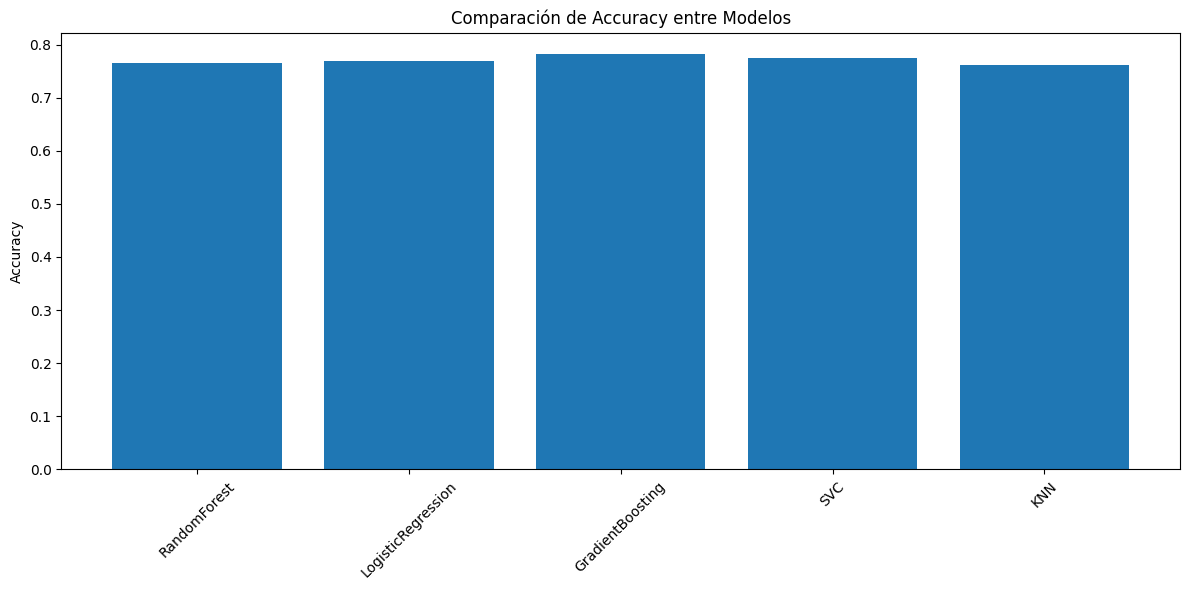

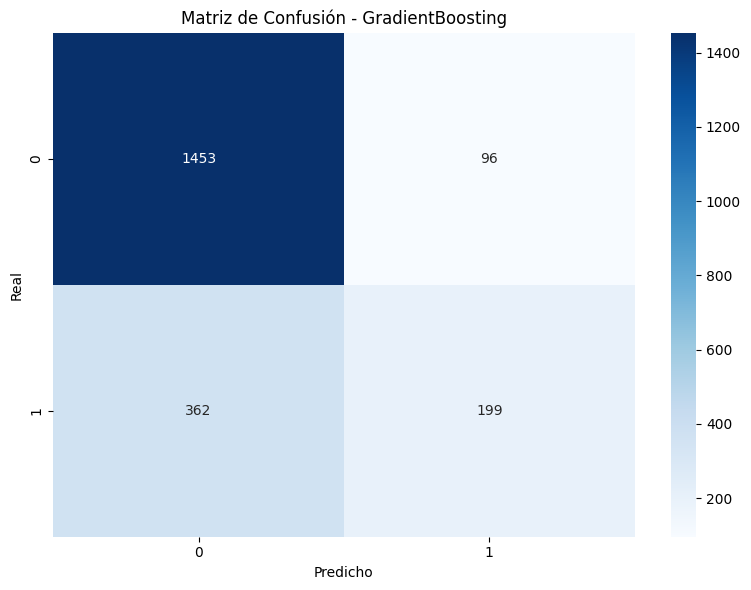

=== Resultados de Clasificación ===

Modelo: GradientBoosting
Accuracy: 0.7829

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.80      0.94      0.86      1549
           1       0.67      0.35      0.46       561

    accuracy                           0.78      2110
   macro avg       0.74      0.65      0.66      2110
weighted avg       0.77      0.78      0.76      2110


Modelo: SVC
Accuracy: 0.7754

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1549
           1       0.63      0.37      0.47       561

    accuracy                           0.78      2110
   macro avg       0.72      0.65      0.66      2110
weighted avg       0.76      0.78      0.75      2110


Modelo: LogisticRegression
Accuracy: 0.7682

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.78      0.94      0.86      1549
  

In [18]:
%%time
# Entrenar modelos de clasificación
clf = ClassificationModel(X_train_clf, y_train_clf, X_test_clf, y_test_clf)
clf.train_models()
clf_results = clf.evaluate_models()

# Visualizar resultados
visualizer = ModelPerformanceVisualizer(classification_model=clf)
visualizer.plot_classification_results()
visualizer.save_visualizations()

# Generar reporte
print(visualizer.generate_summary_report())

# regresion

In [19]:
# Regression task: Predicting 'MonthlyCharges'
X_regression = df[caracteristicas]
y_regression = df['MonthlyCharges']

In [20]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_regression, y_regression, test_size=0.3, random_state=42)

In [21]:
%%time
reg = RegressionModel(X_train_reg, y_train_reg, X_test_reg, y_test_reg)
reg.train_models()
reg_results = reg.evaluate_models()


Entrenando RandomForest...
RandomForest - Mejores parámetros: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 10}
RandomForest - Mejor score CV: 117.8285

Entrenando LinearRegression...
LinearRegression - Mejores parámetros: {}
LinearRegression - Mejor score CV: 598.5338

Entrenando Ridge...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Ridge - Mejores parámetros: {'solver': 'auto', 'alpha': 1.0}
Ridge - Mejor score CV: 598.5334

Entrenando Lasso...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Lasso - Mejores parámetros: {'selection': 'cyclic', 'alpha': 0.1}
Lasso - Mejor score CV: 598.3037

Entrenando ElasticNet...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


ElasticNet - Mejores parámetros: {'l1_ratio': 0.8, 'alpha': 0.1}
ElasticNet - Mejor score CV: 598.7524

Entrenando SVR...
SVR - Mejores parámetros: {'kernel': 'rbf', 'gamma': 'auto', 'C': 10}
SVR - Mejor score CV: 427.1725

Entrenando GradientBoosting...
GradientBoosting - Mejores parámetros: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}
GradientBoosting - Mejor score CV: 114.7125

Entrenando KNN...
KNN - Mejores parámetros: {'weights': 'distance', 'n_neighbors': 9, 'metric': 'manhattan'}
KNN - Mejor score CV: 322.8994

Resultados para RandomForest:
MSE: 116.3761
MAE: 7.7348
R2: 0.8707

Resultados para LinearRegression:
MSE: 583.0293
MAE: 20.2106
R2: 0.3523

Resultados para Ridge:
MSE: 583.0265
MAE: 20.2109
R2: 0.3523

Resultados para Lasso:
MSE: 582.9339
MAE: 20.2251
R2: 0.3524

Resultados para ElasticNet:
MSE: 583.1078
MAE: 20.2635
R2: 0.3522

Resultados para SVR:
MSE: 383.7082
MAE: 15.1491
R2: 0.5737

Resultados para GradientBoosting:
MSE: 116.2820
MAE: 8.1856
R2: 0.870

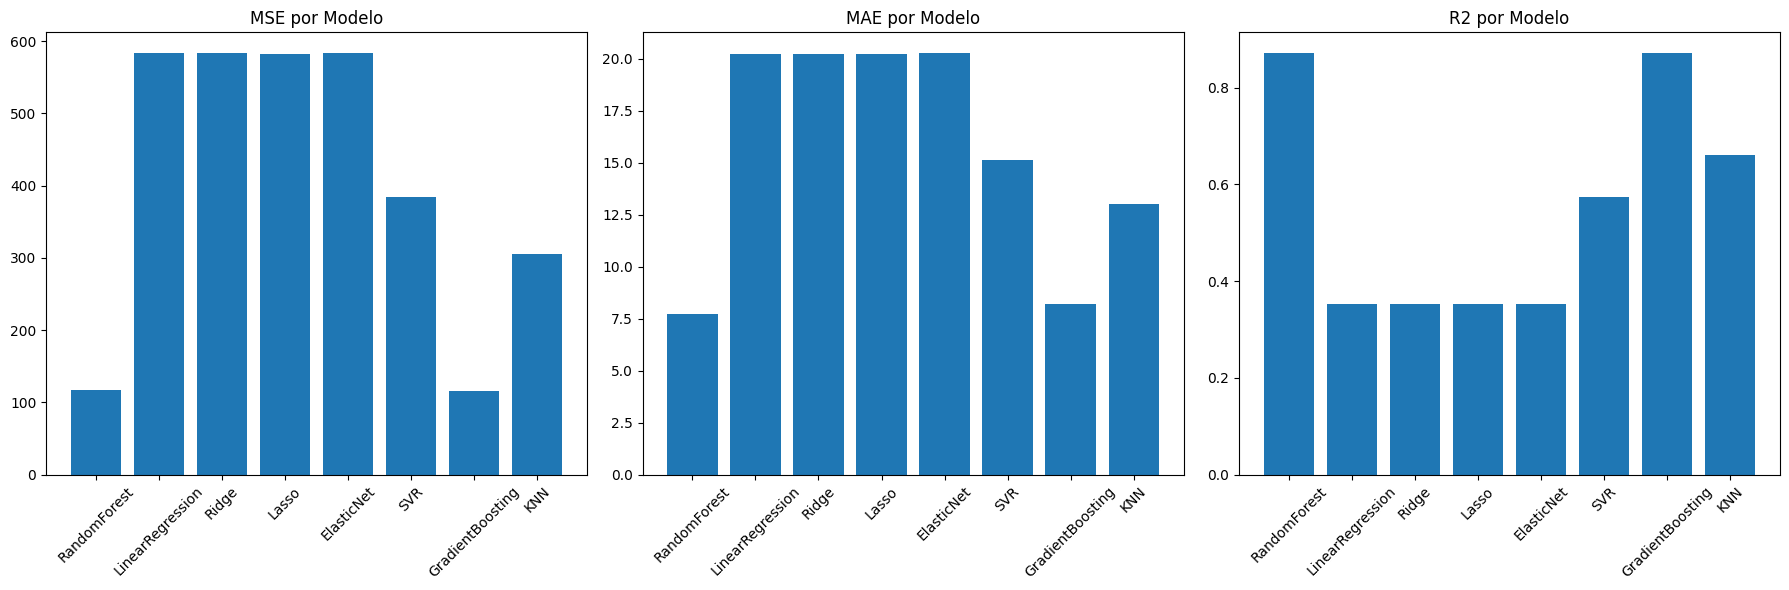

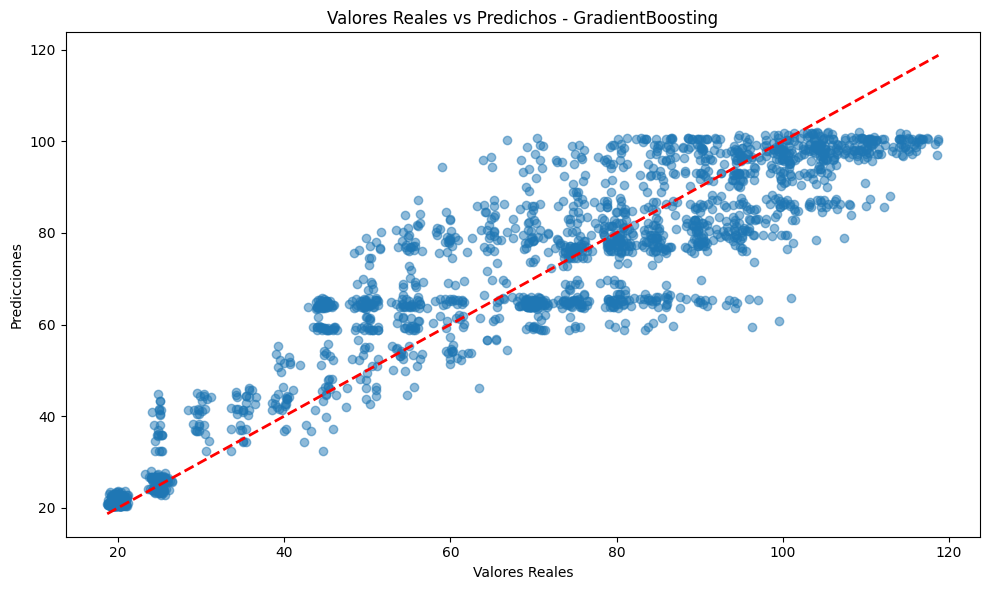


=== Resultados de Regresión ===

Modelo: GradientBoosting
MSE: 116.2820
MAE: 8.1856
R2: 0.8708

Modelo: RandomForest
MSE: 116.3761
MAE: 7.7348
R2: 0.8707

Modelo: KNN
MSE: 304.9369
MAE: 13.0225
R2: 0.6612

Modelo: SVR
MSE: 383.7082
MAE: 15.1491
R2: 0.5737

Modelo: Lasso
MSE: 582.9339
MAE: 20.2251
R2: 0.3524

Modelo: Ridge
MSE: 583.0265
MAE: 20.2109
R2: 0.3523

Modelo: LinearRegression
MSE: 583.0293
MAE: 20.2106
R2: 0.3523

Modelo: ElasticNet
MSE: 583.1078
MAE: 20.2635
R2: 0.3522


In [22]:
# Visualizar resultados
visualizer = ModelPerformanceVisualizer(regression_model=reg)
visualizer.plot_regression_results()
visualizer.save_visualizations()

# Generar reporte
print(visualizer.generate_summary_report())

In [23]:
reg.save_best_model('content/best_regresor')

Modelo guardado exitosamente en: content/best_regresor_model.joblib


{'model': 'content/best_regresor_model.joblib',
 'info': 'content/best_regresor_info.json'}

In [24]:
clf.save_best_model('content/best_clasifier')

Modelo guardado exitosamente en: content/best_clasifier_model.joblib


{'model': 'content/best_clasifier_model.joblib',
 'info': 'content/best_clasifier_info.json'}